# BAT.jl: Background + Signal Analysis 

***
In this exercise, we will get familiar with fitting a model to datasets of events, measured from your experiment, which are supplied as histograms. 

You will have access to two different datasets, which you will use separately to construct knowledge of the background of your experiment and later on to look for a signal using a Bayesian approach. The first dataset contains a large population of events and this is the one you will use to perform a Bayesian fit of the model for the background of your experiment. 

After you have obtained a model of the background, you can use the second dataset, which has a low event population, to test whether a signal is present by computing the evidence for both the background model only and the background model with a superimposed signal. 

Given the evidence for both hypotheses, you will decide whether a signal is present using the  [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor).

***


Note: This tutorial is written in the style of a cloze text. Parts that have to be filled out by you are marked `#=FILLME=#`.

The [the tutorial section](https://bat.github.io/BAT.jl/stable/tutorial/) of the BAT.jl documentation should prove helpful.

***

To start we need to import some packages that we will need for our analysis:

In [1]:
using BAT
using Random
using Distributions
using IntervalSets
using ValueShapes
using Plots
using StatsBase
using LinearAlgebra
using Statistics
using ArraysOfArrays

gr(palette = :inferno, size=(750,500))

Plots.GRBackend()

## 1. Generate Data

Let us generate `N_background=1500` samples for the background only data. And `N=440` samples for background+signal data. 

In [2]:
bins=0:0.5:30
N_background = 1500
λ = 10

data_background = rand(Truncated(Exponential(λ), 0, 30), N_background)
hist_background = append!(Histogram(bins), data_background);

In [3]:
N_signal = 40
N_s_background = 400
μ_true = 15.0
σ_true = 1.0

data_signal =  vcat(
    rand(Truncated(Exponential(λ), 0, 30), N_s_background),
    rand(Normal( μ_true, σ_true), N_signal)
)

hist_signal = append!(Histogram(bins), data_signal);

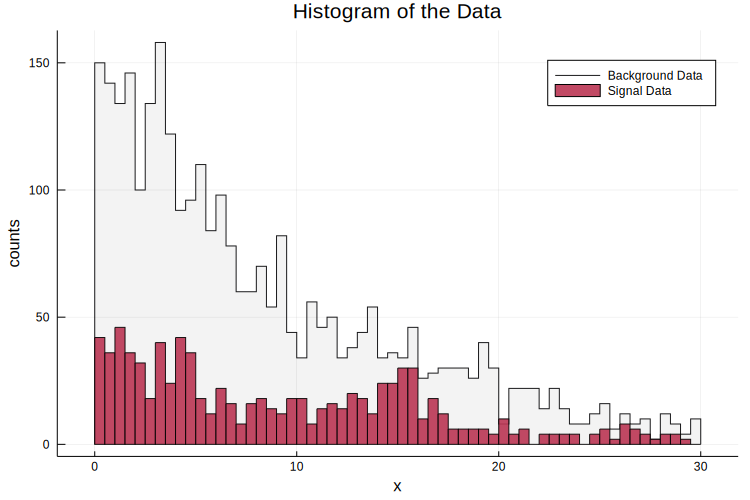

In [4]:
plot(normalize(hist_background, mode=:density), alpha=0.9, color=1, fillalpha = 0.05, linewidth = 0.0, label="")
plot!(normalize(hist_background, mode=:density), seriestype = :steps, alpha=0.9, color=1,  label="Background Data")
plot!(normalize(hist_signal, mode=:density), alpha=0.9, color=3, label="Signal Data")
plot!(xlabel = "x", ylabel="counts", title="Histogram of the Data")

## 2. Definition of Model Functions & Likelihood

Given the data histograms, we have to declare the model functions we want to fit. You can notice that you can use both a scalar ($\lambda$) or a vector of variables ($A$) to define the parameters of your model. 

In [5]:
function background_model(p::NamedTuple{(:A, :λ)}, x::Real)
    p.A[1] + p.A[2]*exp(-p.λ*x)
end

function background_signal_model(p::NamedTuple{(:A, :λ, :D, :x_0, :σ)}, x::Real)
    p.A[1] + p.A[2]*exp(-p.λ*x) + (p.D/(sqrt(2*pi*p.σ^2)))*exp(-((x - p.x_0)^2)/p.σ^2)  
end

background_signal_model (generic function with 1 method)

Now, we need to define a likelihood function for our problem:

In [6]:
function make_hist_likelihood(h::Histogram, f::Function)
    params -> begin
        # Histogram counts for each bin as an array:
        counts = h.weights

        # Histogram binning, has length (length(counts) + 1):
        binning = h.edges[1]

        # sum log-likelihood value over bins:
        ll_value::Float64 = 0.0
        
        for i in eachindex(counts)
            # Hint: Hava a look at the tutorial in the BAT.jl documentation.

            # Get information about current bin:
            bin_left, bin_right = binning[i], binning[i+1]
            bin_width = bin_right - bin_left
            bin_center = (bin_right + bin_left) / 2

            observed_counts = counts[i]

            # Simple mid-point rule integration of fit function `f` over bin:
            expected_counts = bin_width * f(params, bin_center)

            # Add log of Poisson probability for bin:
            ll_value += logpdf(Poisson(expected_counts), observed_counts)
            
            #!EX #=FILLME=#
            #!EX
            #!EX ll_value += #=FILLME=#
        end

        return LogDVal(ll_value)
    end 
end 

make_hist_likelihood (generic function with 1 method)

In [7]:
algorithm = MetropolisHastings()
nsamples = 2*10^5
nchains = 5
ENV["JULIA_INFO"] = "BAT";

## 3. Background Analysis: 

Now we'll perform a Bayesian fit of the background histogram, using BAT, to infer the model parameters from the data histogram.

In [8]:
likelihood_bm = make_hist_likelihood(hist_background, background_model);

We need to choose a sensible prior for the fit. Try an interval from 0 to 1000 for the entries of a `A` (note that `A` is a vector) and an interval from 0 to 20 for `λ`:

In [9]:
prior_bm = NamedTupleDist(
    A = [0.0 .. 1000.0, 0 .. 10000.0],
    λ = 0.0 .. 20.0
);

#!EX prior_bm = NamedTupleDist(
#!EX     A = [#=FILLME=#, #=FILLME=#],
#!EX     λ = #=FILLME=#
#!EX );

In [10]:
parshapes_bm = varshape(prior_bm)
posterior_bm = PosteriorDensity(likelihood_bm, prior_bm);

In [11]:
samples_bm, chains_bm = bat_sample(posterior_bm, (nsamples, nchains), algorithm);

┌ Info: Trying to generate 5 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 5 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 5 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 5 chains, 0 tuned, 5 converged.
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 5 chains, 0 tuned, 5 converged.
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 5 finished, 5 chains, 0 tuned, 5 conv

In [12]:
println("Mode: $(mode(samples_bm))")

Mode: ShapedAsNT((A = [0.005855893252237319, 160.68824733833958], λ = 0.10216374433162312))


In [13]:
mode_parms_bm = mode(samples_bm)[1]

(A = [0.005855893252237319, 160.68824733833958], λ = 0.10216374433162312)

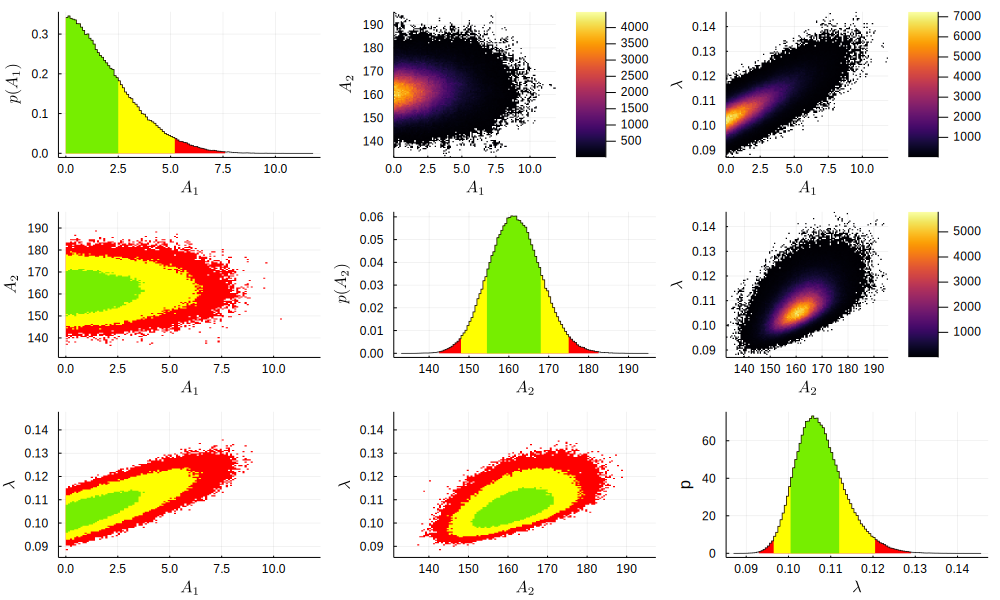

In [14]:
plot(samples_bm, vsel=[1,2,3], param_labels=["A_1","A_2","\$\\lambda\$"])

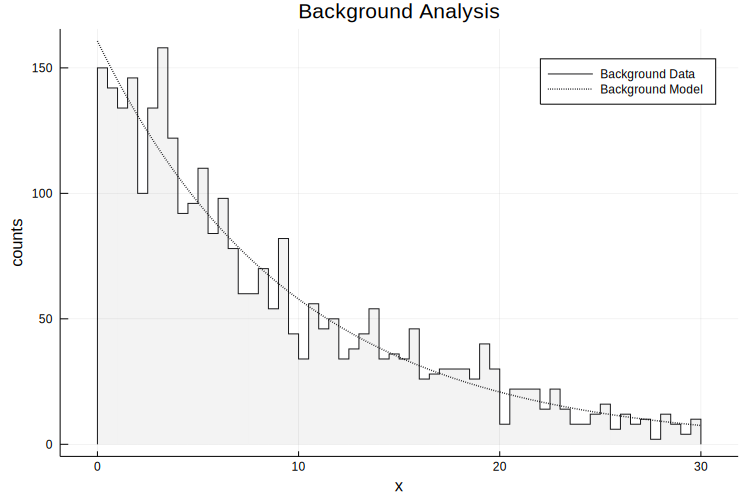

In [15]:
plot(normalize(hist_background, mode=:density), alpha=0.9, color=1, fillalpha = 0.05, linewidth = 0.0, label="")
plot!(normalize(hist_background, mode=:density), seriestype = :steps, alpha=0.9, color=1,  label="Background Data")

plot!(xlabel = "x", ylabel="counts", title="Background Analysis")

plot!(
    0:0.1:30, x -> background_model(mode_parms_bm, x),
    label = "Background Model", lw=1.5, color=1,  linestyle = :dot
)


### Histogram as a prior: 

We would like now to use posterior distribution for $\lambda$ as a prior for signal+background fit. Let us construct histogram for $\lambda$ by using MCMC samples 

In [16]:
samples = flatview(unshaped.(samples_bm.v))[3,:]
λ_hist = fit(Histogram, samples, FrequencyWeights(samples_bm.weight), nbins = 150)

Histogram{Int64,1,Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}}
edges:
  0.087:0.0005:0.146
weights: [3, 0, 15, 46, 38, 65, 99, 230, 327, 486  …  20, 3, 5, 8, 8, 2, 3, 0, 3, 9]
closed: left
isdensity: false

## 4. Background + Signal Analysis: 

Let us use the second dataset, which has much fewer samples, to infer parameters of the signal model. Let us define a prior for the fit parameters including histogram for $\lambda$

In [17]:
BAT.EmpiricalDistributions.UvBinnedDist

EmpiricalDistributions.UvBinnedDist

In [18]:
likelihood_signal = make_hist_likelihood(hist_signal, background_signal_model);

prior_signal = NamedTupleDist(
    A = [0.0 .. 1000.0, 0 .. 10000.0],
    λ = BAT.EmpiricalDistributions.UvBinnedDist(λ_hist),
    D = 0.0..1000, 
    x_0 = 0 .. 30, 
    σ = 0.5 .. 10.0
);

parshapes_signal = varshape(prior_signal)
posterior_signal = PosteriorDensity(likelihood_signal, prior_signal);

┌ Warning: var will default to corrected=true in the future. Use corrected=false for previous behaviour.
│   caller = ip:0x0
└ @ Core :-1


In [19]:
samples_signal, chains_signal = bat_sample(posterior_signal, (nsamples, nchains), algorithm);

┌ Info: Trying to generate 5 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 5 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 5 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 5 finished, 5 chains, 0 tuned, 5 conv

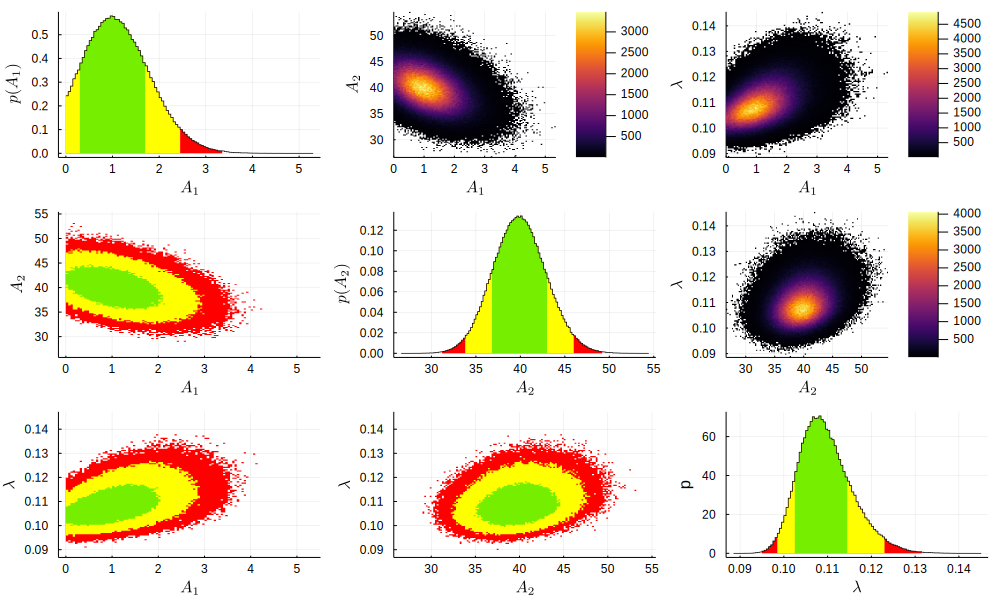

In [20]:
plot(samples_signal, vsel=[1,2,3], param_labels=["A_1","A_2","\$\\lambda\$"])

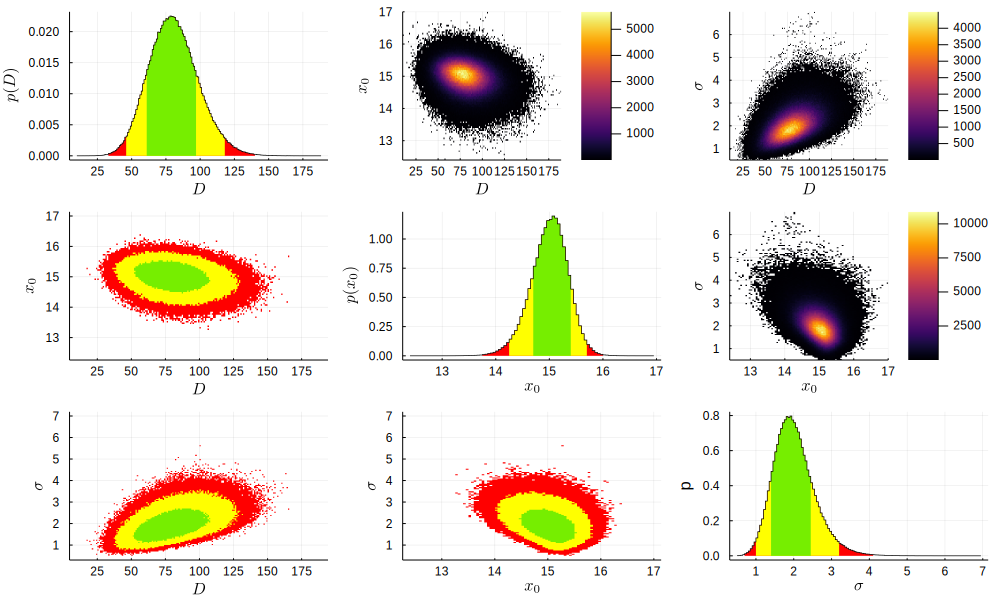

In [21]:
plot(samples_signal, vsel=[4,5,6], param_labels=["D","x_0","\$\\sigma\$"])

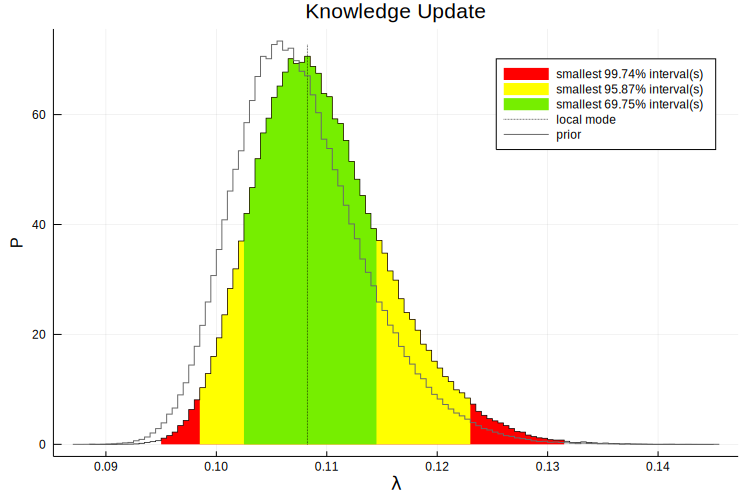

In [22]:
plot(samples_signal, 3)
plot!(prior_signal, 3)
plot!(ylabel="P(\\lambda)", xlabel="\\lambda", title="Knowledge Update")

In [23]:
println("Mode: $(mode(samples_signal))")

Mode: ShapedAsNT((A = [0.9151713646633189, 40.20967950327992], λ = 0.10668844472730069, D = 76.89037891276948, x_0 = 15.07450771513177, σ = 1.7108228995464227))


In [24]:
mode_parms_signal = mode(samples_signal)[1]

(A = [0.9151713646633189, 40.20967950327992], λ = 0.10668844472730069, D = 76.89037891276948, x_0 = 15.07450771513177, σ = 1.7108228995464227)

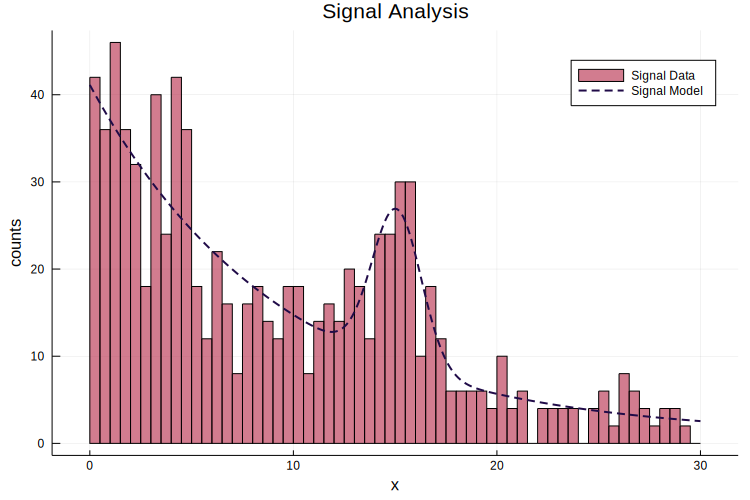

In [25]:
plot(normalize(hist_signal, mode=:density), fillalpha=0.65, color=3, label="Signal Data")
plot!(
    0:0.1:30, x -> background_signal_model(mode_parms_signal, x),
    label = "Signal Model", lw=2, color=6, linestyle = :dash
)
plot!(xlabel = "x", ylabel="counts", title="Signal Analysis")

The Bayes factor for the signal model can be computed in the following way

In [26]:
evidence_signal = bat_integrate(samples_signal).result

┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	500000 / 500000	Parameters:	6
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/integration/ahmi/harmonic_mean_integration.jl:117
┌ Info: Create Space Partitioning Tree
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/integration/ahmi/harmonic_mean_integration.jl:129
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/integration/ahmi/harmonic_mean_integration.jl:145
┌ Info: Determine Tolerances for Hyperrectangle Creation
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/integration/ahmi/harmonic_mean_integration.jl:165
┌ Info: Create 73 Hyperrectangles using 20

2.531e-66 ± 1.4999999999999998e-68

## 5. Signal vs. No signal: 

Let us now analyze the same dataset under the assumption that we have no signal events

In [27]:
likelihood_nosignal = make_hist_likelihood(hist_signal, background_model);

prior_nosignal = NamedTupleDist(
    A = [0.0 .. 1000.0, 0 .. 10000.0],
    λ = BAT.EmpiricalDistributions.UvBinnedDist(λ_hist),
);

#!EX prior_nosignal = NamedTupleDist(
#!EX     A = [#=FILLME=#, #=FILLME=#],
#!EX     λ = #=FILLME=#
#!EX );

parshapes_nosignal = varshape(prior_nosignal)
posterior_nosignal = PosteriorDensity(likelihood_nosignal, prior_nosignal);

In [28]:
samples_nosignal, chains_nosignal = bat_sample(posterior_nosignal, (nsamples, nchains), algorithm);

┌ Info: Trying to generate 5 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 5 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 5 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 5 chains, 0 tuned, 5 converged.
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 5 chains, 0 tuned, 5 converged.
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 5 finished, 5 chains, 0 tuned, 5 conv

In [29]:
println("Mode: $(mode(samples_nosignal))")

Mode: ShapedAsNT((A = [1.6789551320593927, 42.10955464294959], λ = 0.10300642160127257))


In [30]:
mode_parms_nosignal = mode(samples_nosignal)[1]

(A = [1.6789551320593927, 42.10955464294959], λ = 0.10300642160127257)

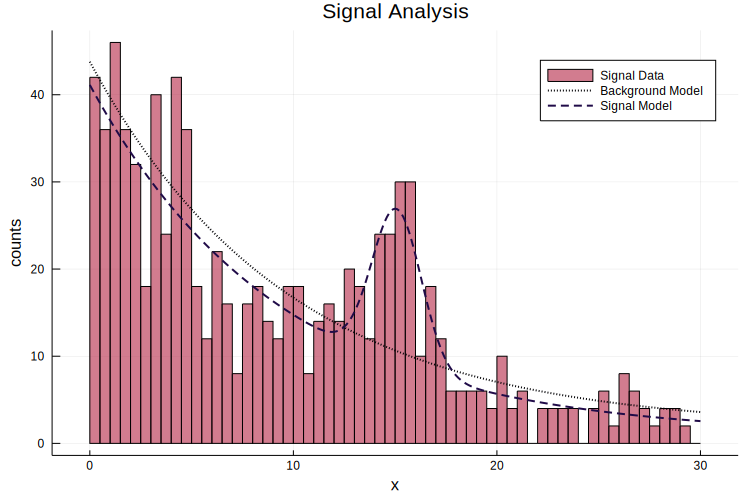

In [31]:
plot(normalize(hist_signal, mode=:density), fillalpha=0.65, color=3, label="Signal Data")

plot!(
    0:0.1:30, x -> background_model(mode_parms_nosignal, x),
    label = "Background Model", lw=2, color=1,  linestyle = :dot
)
plot!(
    0:0.1:30, x -> background_signal_model(mode_parms_signal, x),
    label = "Signal Model", lw=2, color=6, linestyle = :dash
)
plot!(xlabel = "x", ylabel="counts", title="Signal Analysis")

The Bayes factor for this case is equal to

In [32]:
evidence_nosignal = bat_integrate(samples_nosignal).result

┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	500000 / 500000	Parameters:	3
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/integration/ahmi/harmonic_mean_integration.jl:117
┌ Info: Create Space Partitioning Tree
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/integration/ahmi/harmonic_mean_integration.jl:129
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/integration/ahmi/harmonic_mean_integration.jl:145
┌ Info: Determine Tolerances for Hyperrectangle Creation
└ @ BAT /user/.julia/packages/BAT/NLTYC/src/integration/ahmi/harmonic_mean_integration.jl:165
┌ Info: Create 49 Hyperrectangles using 20

9.795000000000002e-72 ± 5.2e-74

Finally, let us compare Bayes factors for these two assumptions: 

In [33]:
evidence_signal / evidence_nosignal

258400.0 ± 2100.0

    Tasks: 
    
    1) Change the number of signal/background events and see for which values we no longer detect the signal. Explore how the binning of the data effects analysis. 
    
    2) Assume that we do not have the dataset with the background only measurements, and we use a flat prior for the parameter lambda. Explore how this effects MCMC sampling. 